โรคมะเร็งผิวหนัง นับเป็นปัญหาใหญ่ในทางสาธารณสุข ทุก ๆ ปี ในประเทศสหรัฐอเมริกา เราจะพบผู้ป่วยใหม่ มากกว่า 5 ล้านราย มะเร็วผิวหนัง Melanoma เป็นมะเร็งผิวหนังชนิดที่ร้ายแรงที่สุด เป็นมะเร็วผิวหนังชนิดที่คร่าชีวิตคนมากที่สุด ในปี 2015 ทั่วโลก มีการตรวจพบ Melanoma มากกว่า 350,000 เคส โดยมีผู้ป่วยเสียชีวิต 60,000 คน ถึงแม้อัตราการเสียชีวิตจะสูง แต่ถ้ามีการตรวจพบตั้งแต่ระยะเริ่มต้น เราสามารถเพิ่มอัตราการรอดชีวิต ได้มากกว่า 95%

# 0. Magic Commands

ให้ใส่ไว้บนสุดทุก [Jupyter Notebook](https://www.bualabs.com/archives/184/advance-tutorial-to-jupyter-notebook-quick-start-in-thai-language-ep-3/) เป็นการสั่งให้ Notebook ก่อนรัน ให้รีโหลด Library ภายนอกที่เรา import ไว้ใหม่โดยอัตโนมัติ 

และให้พล็อตกราฟ matplotlib ใน Output ของ cell แบบ code ได้เลย

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
! nvidia-smi

Tue May 12 09:36:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Install & Import Library

ติดตั้ง [fastai2](https://www.bualabs.com/archives/4102/tutorial-fastai2-oxford-pets-dog-cat-37-class-machine-learning-deep-neural-networks-image-classification-ep-7/) หรือ fastai version 2 และ Import Library ที่เราจะใช้ 

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [0]:
# Colab

! pip install kaggle --upgrade -q
! pip install fastai2 -q
! pip install kornia -q

Import 3 Package ย่อย คือ basics, vision.all, callback.all

การ import * หมายความว่า import ทุกอย่างที่อยู่ใน package ทำให้เราไม่ได้ต้องมา import ทีละ class การ import แบบนี้ เหมาะสำหรับการทดลองอะไรใหม่ ๆ เพราะเราไม่ต้องย้อนมาแก้ import ทุกครั้งเมื่อต้องการใช้ class ใหม่ ๆ แต่ไม่แนะนำสำหรับใช้งานจริงบน Production


In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.callback.cutmix import CutMix

from kornia.losses import focal

เราจะกำหนด Random Seed จะได้ผลลัพธ์ที่เหมือนกันทุกครั้ง จะได้สะดวกในการเปรียบเทียบ

In [0]:
np.random.seed(42)

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

In [0]:
dataset = 'kmader/skin-cancer-mnist-ham10000'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# # VM
# config_path = Path(os.getenv("HOME"))
# data_path = config_path/"datasets"/dataset

# data_path.mkdir(parents=True, exist_ok=True)
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Dataset

ในเคสนี้ เราจะ Download ข้อมูล Dataset ที่เกี่ยวข้องทั้งหมดมาเก็บไว้ แบ่งเป็นรูปถ่ายโรคมะเร็งผิวหนังต่าง ๆ 

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [0]:
# !kaggle datasets download {dataset} -p "{data_path}" --unzip

ดูว่าแตก zip มาได้ไฟล์อะไรบ้าง 

In [0]:
data_path.ls()

(#9) [Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/ham10000_images_part_2'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/HAM10000_images_part_2'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/HAM10000_images_part_1'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/ham10000_images_part_1'),Path('/content/datasets/kmader/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')]

In [0]:
# (data_path/"ham10000_images_part_1").ls()

ย้ายข้อมูลรูปภาพไปไว้ Folder เดียวกัน จะได้สะดวก

In [0]:
# ! mv {(data_path/"ham10000_images_part_2")}/* {(data_path/"ham10000_images_part_1")}

# 4. Data

อ่านไฟล์ CSV ขึ้นมา ดูข้อมูลเพิ่มเติม เช่น Label

In [0]:
csv_file = data_path/"HAM10000_metadata.csv"

Label อยู่ใน Column dx เป็นตัวย่อ

In [0]:
df = pd.read_csv(csv_file)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


สร้าง Dict ตัวย่อ เป็น คำแปล ชื่อหมวดหมู่ของโรค

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

เอามา Map ลง Dataframe เพื่อใช้เป็น Label

In [0]:
df.dx = df.dx.astype('category', copy=True)
df['labels'] = df.dx.cat.codes 
df['lesion'] = df.dx.map(lesion_type_dict)
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,labels,lesion
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,4,Melanoma
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,5,Melanocytic nevi
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,4,Melanoma
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,2,Benign keratosis
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,5,Melanocytic nevi


นับจำนวนข้อมูลแต่ละ Class

In [0]:
df.lesion.value_counts()

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64

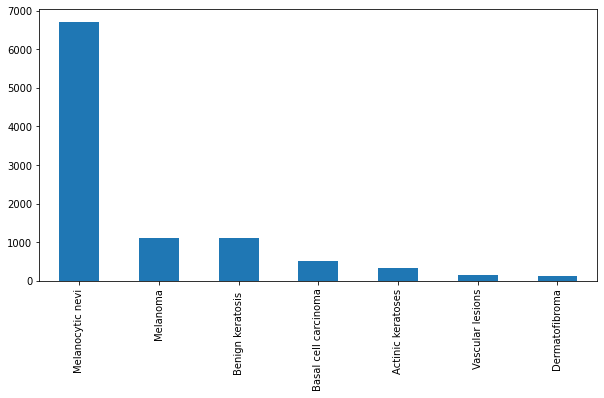

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['lesion'].value_counts().plot(kind='bar', ax=ax1)

# 5. Data Pipeline

สร้าง [Data Pipeline](https://www.bualabs.com/archives/2693/what-is-data-pipeline-data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) ในการแปลงข้อมูลก่อน Feed เข้าสู่ Model

กำหนดขนาด [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/)

In [0]:
bs = 64

Transform แต่ละรูป ด้วยการ สุ่มย่อ แล้ว Crop ให้ได้ขนาดเท่ากันทุกรูป เพื่อจัดเข้า Batch

In [0]:
item_tfms = RandomResizedCrop(420, min_scale=0.7, ratio=(1., 1.))

ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ทำ Transform ทีละ Batch ด้วย [GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) แล้ว [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/)

In [0]:
batch_tfms = [*aug_transforms(size=128, max_rotate=180., flip_vert=True), Normalize()]

สร้าง DataBlock กำหนดค่าต่าง ๆ ใน [Data Pipeline](https://www.bualabs.com/archives/2693/what-is-data-pipeline-data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/)

In [0]:
cancer = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader('image_id', pref=f'{data_path}/ham10000_images_part_1/', suff='.jpg'), 
                 get_y=ColReader('lesion'), 
                 splitter=RandomSplitter(), 
                 item_tfms=item_tfms, 
                 batch_tfms=batch_tfms)

In [0]:
# cancer.summary(df)

สร้าง DataLoaders จาก DataBlock

In [0]:
dls = cancer.dataloaders(df, bs=bs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


แสดงตัวอย่าง ข้อมูล 1 Batch

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


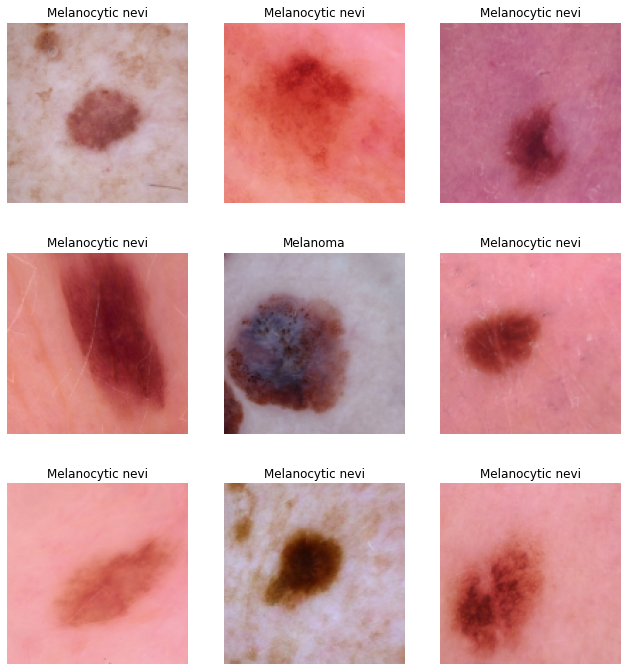

In [0]:
dls.show_batch(max_n=9, figsize=(11, 12))

ดูใน vocab Dictionary มี 7 Class

In [0]:
dls.vocab

(#7) ['Actinic keratoses','Basal cell carcinoma','Benign keratosis ','Dermatofibroma','Melanocytic nevi','Melanoma','Vascular lesions']

# 6. Model 

## Focal Loss

เนื่องจากจำนวนข้อมูล แต่ละ Class แตกต่างกันมาก เรียกว่า Class Imbalance เราจะใช้ Loss Function ที่แก้ปัญหานี้ เรียกว่ FocalLoss

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

เราจะสร้าง class ใหม่มาห่อ focal.FocalLoss เนื่องจาก fastai ต้องการ method activation และ decodes ในการเรียกใช้ show_results, plot_top_losses ด้านล่าง 

In [0]:
class CustomFocalLoss(focal.FocalLoss):
    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(CustomFocalLoss, self).__init__(alpha, gamma, reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [0]:
# focal.FocalLoss??

In [0]:
kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'}
loss_func = CustomFocalLoss(**kwargs)

## ResNet50

ใช้ Ranger Optimizer ซึ่งเป็น การผสมกันระหว่าง RAdam และ LookAhead จะอธิบายต่อไป

In [0]:
ranger??

In [0]:
opt_func = ranger

เราจะใช้โมเดล [Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) ResNet50 เทรนแบบ Mixed Precision 

In [0]:
learn = cnn_learner(dls, resnet50, pretrained=True, 
                    loss_func=loss_func, 
                    opt_func=opt_func, 
                    cbs=[ShowGraphCallback], 
                    metrics=error_rate).to_fp16()

In [0]:
# learn.summary()

# 7. Train

## Fine-Tune

เรียก Fine-tune ให้ Learner เทรนแบบ Head 1 Epoch แล้ว Unfreeze เทรนต่อทั้งโมเดล

epoch,train_loss,valid_loss,error_rate,time
0,0.943034,0.535350,0.364453,02:00


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


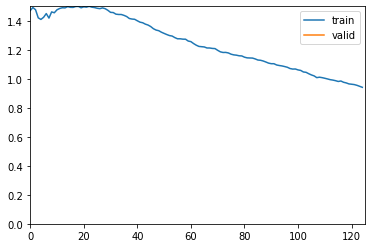

epoch,train_loss,valid_loss,error_rate,time
0,0.645236,0.372260,0.280080,02:02
1,0.445429,0.239645,0.228657,02:03
2,0.318916,0.199452,0.212681,02:02
3,0.251568,0.161806,0.190714,02:02
4,0.200812,0.141688,0.185721,02:03
5,0.184886,0.143703,0.183724,02:02


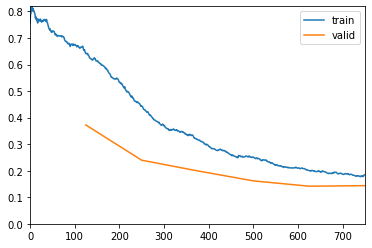

In [0]:
learn.fine_tune(8)

In [0]:
learn.save("fine-tune1")

เพียงสิบกว่านาที เราได้ Error Rate เท่ากับ 0.18 หรือ Accuracy เท่ากับ 82%

# 8. ดูผลลัพธ์

ถ้าเราดูแค่ [Metrics](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) Error Rate อย่างเดียว ว่ากี่เปอร์เซ็นต์ เราอาจจะไม่เห็นภาพว่า Model ทำงานได้ผลลัพธ์อย่างไร เราควรดูข้อมูลจริง รูปจริง Label จริง ด้วย ว่าโมเดล Predict อะไรออกมา

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


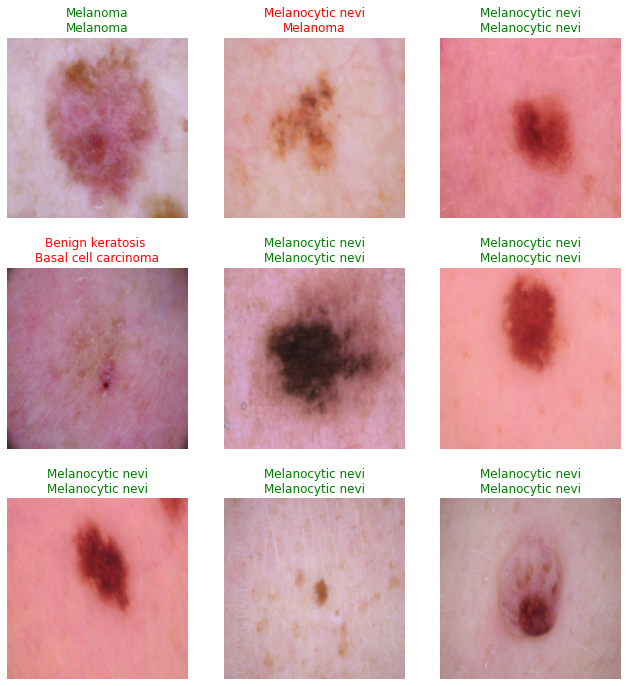

In [0]:
learn.show_results(max_n=9, figsize=(11, 12))

เราจะสร้าง ClassificationInterpretation เป็น class ที่มาช่วยตีความผลลัพธ์ ให้เราดูเข้าใจง่ายขึ้น

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

len(dls.valid_ds) == len(losses) == len(idxs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


True

เราจะดูรูปที่มีค่า [Loss](https://www.bualabs.com/archives/2673/what-is-loss-function-cost-function-error-function-loss-function-how-cost-function-work-machine-learning-ep-1/) มากที่สุด 9 อันดับแรก หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด Class ด้วยความมั่นใจ (Probability) มากที่สุด 9 อันดับแรก

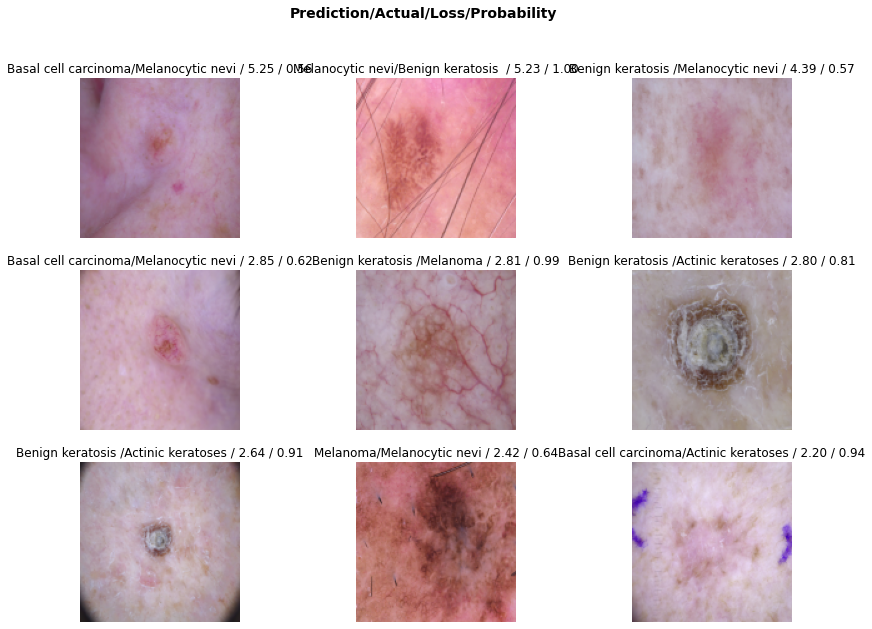

In [0]:
interp.plot_top_losses(9, figsize=(14, 10))

สั่ง plot_confusion_matrix จะแสดงตาราง [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ตัดกันของหมวดหมู่ทั้งหมด 7 x 7 ว่าข้อมูลจริงคือโรคอะไร (Row) แล้วโมเดลทายว่าโรคอะไร (Column) สังเกตุที่ทายถูกจะเป็นเส้นแทยงมุมตรงกลาง

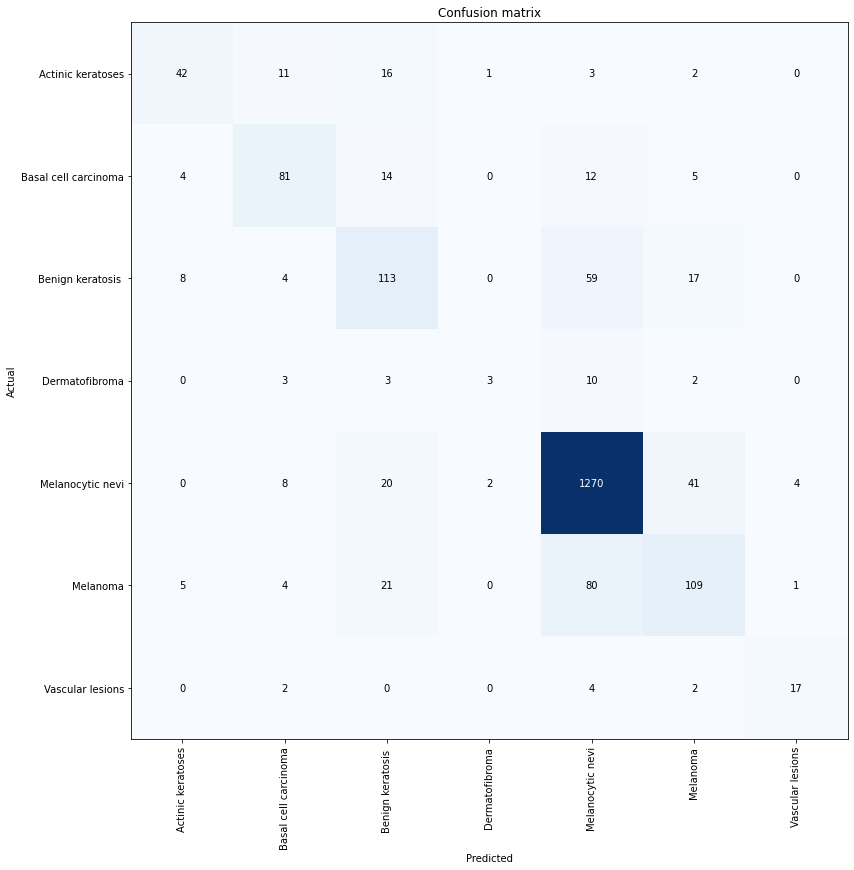

In [0]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=72)

เรียกดู most_confused คือ โรคที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [0]:
interp.most_confused(min_val=3)

[('Melanoma', 'Melanocytic nevi', 80),
 ('Benign keratosis ', 'Melanocytic nevi', 59),
 ('Melanocytic nevi', 'Melanoma', 41),
 ('Melanoma', 'Benign keratosis ', 21),
 ('Melanocytic nevi', 'Benign keratosis ', 20),
 ('Benign keratosis ', 'Melanoma', 17),
 ('Actinic keratoses', 'Benign keratosis ', 16),
 ('Basal cell carcinoma', 'Benign keratosis ', 14),
 ('Basal cell carcinoma', 'Melanocytic nevi', 12),
 ('Actinic keratoses', 'Basal cell carcinoma', 11),
 ('Dermatofibroma', 'Melanocytic nevi', 10),
 ('Benign keratosis ', 'Actinic keratoses', 8),
 ('Melanocytic nevi', 'Basal cell carcinoma', 8),
 ('Basal cell carcinoma', 'Melanoma', 5),
 ('Melanoma', 'Actinic keratoses', 5),
 ('Basal cell carcinoma', 'Actinic keratoses', 4),
 ('Benign keratosis ', 'Basal cell carcinoma', 4),
 ('Melanocytic nevi', 'Vascular lesions', 4),
 ('Melanoma', 'Basal cell carcinoma', 4),
 ('Vascular lesions', 'Melanocytic nevi', 4),
 ('Actinic keratoses', 'Melanocytic nevi', 3),
 ('Dermatofibroma', 'Basal cell car

# 9. Progressive Resizing

เราจะค่อย ๆ Fine-tune โดยเพิ่มขนาดรูปที่ใช้ในการเทรน จาก 128 เป็น 224, 320, 420 ทีละ Step ไปเรื่อย ๆ เพื่อลดการ Overfit

## 224

In [0]:
batch_tfms = [*aug_transforms(size=224, max_rotate=180., flip_vert=True), Normalize()]
cancer = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader('image_id', pref=f'{data_path}/ham10000_images_part_1/', suff='.jpg'), 
                 get_y=ColReader('lesion'), 
                 splitter=RandomSplitter(), 
                 item_tfms=item_tfms, 
                 batch_tfms=batch_tfms)

dls = cancer.dataloaders(df, bs=bs)
learn = cnn_learner(dls, resnet50, pretrained=True, 
                    loss_func=loss_func, 
                    opt_func=opt_func, 
                    cbs=[ShowGraphCallback], 
                    metrics=error_rate).to_fp16()

epoch,train_loss,valid_loss,error_rate,time
0,0.230626,0.142221,0.180729,02:05


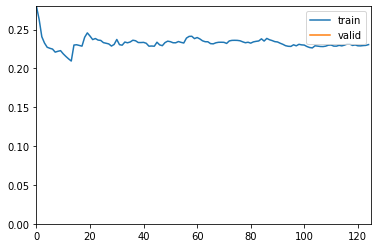

epoch,train_loss,valid_loss,error_rate,time
0,0.179508,0.120190,0.162257,02:09
1,0.167649,0.114904,0.167249,02:09
2,0.143846,0.112956,0.166750,02:09
3,0.123480,0.096047,0.150275,02:09
4,0.095191,0.084539,0.132302,02:09
5,0.083206,0.077694,0.129805,02:10
6,0.068516,0.078000,0.123315,02:09
7,0.060398,0.077511,0.122317,02:09


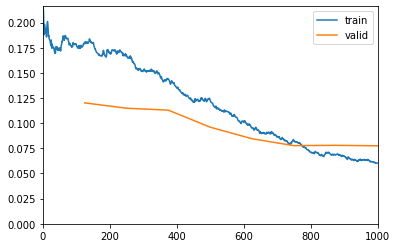

In [0]:
learn.load("fine-tune1")
learn.freeze()
learn.fine_tune(8)
learn.save("fine-tune2")

## 320

In [0]:
batch_tfms = [*aug_transforms(size=320, max_rotate=180., flip_vert=True), Normalize()]
cancer = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader('image_id', pref=f'{data_path}/ham10000_images_part_1/', suff='.jpg'), 
                 get_y=ColReader('lesion'), 
                 splitter=RandomSplitter(), 
                 item_tfms=item_tfms, 
                 batch_tfms=batch_tfms)

dls = cancer.dataloaders(df, bs=bs)
learn = cnn_learner(dls, resnet50, pretrained=True, 
                    loss_func=loss_func, 
                    opt_func=opt_func, 
                    cbs=[ShowGraphCallback], 
                    metrics=error_rate).to_fp16()

epoch,train_loss,valid_loss,error_rate,time
0,0.086905,0.057864,0.095357,02:16


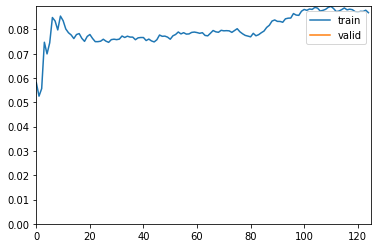

epoch,train_loss,valid_loss,error_rate,time
0,0.079155,0.051035,0.086370,02:21
1,0.079475,0.055425,0.095856,02:21
2,0.080852,0.059909,0.104843,02:21
3,0.075777,0.058274,0.098852,02:20
4,0.061214,0.060376,0.105841,02:20
5,0.055298,0.056085,0.097853,02:21
6,0.045791,0.046597,0.084373,02:21
7,0.032275,0.049844,0.084873,02:21
8,0.031965,0.047846,0.082376,02:22
9,0.026542,0.047624,0.078882,02:21


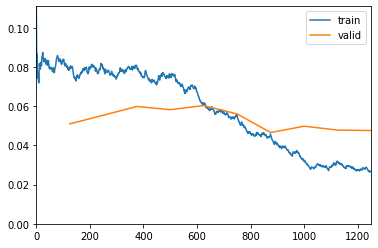

In [0]:
learn.load("fine-tune2")
learn.freeze()
learn.fine_tune(10)
learn.save("fine-tune3")

## 420

In [0]:
batch_tfms = [*aug_transforms(max_rotate=180., flip_vert=True), Normalize()]
cancer = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader('image_id', pref=f'{data_path}/ham10000_images_part_1/', suff='.jpg'), 
                 get_y=ColReader('lesion'), 
                 splitter=RandomSplitter(), 
                 item_tfms=item_tfms, 
                 batch_tfms=batch_tfms)

dls = cancer.dataloaders(df, bs=bs)
learn = cnn_learner(dls, resnet50, pretrained=True, 
                    loss_func=loss_func, 
                    opt_func=opt_func, 
                    cbs=[ShowGraphCallback], 
                    metrics=error_rate).to_fp16()

epoch,train_loss,valid_loss,error_rate,time
0,0.052923,0.056167,0.091862,02:30


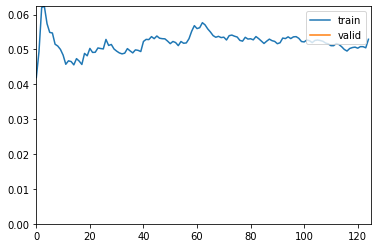

epoch,train_loss,valid_loss,error_rate,time
0,0.043064,0.064427,0.102846,02:46
1,0.050732,0.075342,0.129805,02:46
2,0.057726,0.063973,0.093360,02:46
3,0.045747,0.059578,0.095856,02:47
4,0.038574,0.064246,0.107339,02:49
5,0.032657,0.042099,0.069396,02:49
6,0.022269,0.042050,0.068397,02:49
7,0.018919,0.042126,0.066400,02:49


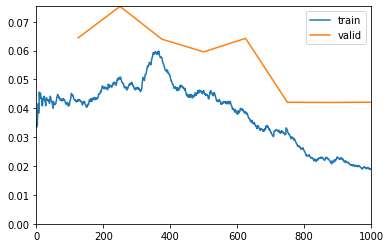

In [0]:
learn.load("fine-tune3")
learn.freeze()
learn.fine_tune(8)
learn.save("fine-tune4")

หลังจาก Progressive Resizing มาหลาย Step เราได้ Error Rate เท่ากับ 0.07 หรือ Accuracy เท่ากับ 93%

In [0]:
learn.load("fine-tune4")

พล็อต [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) อีกรอบ 

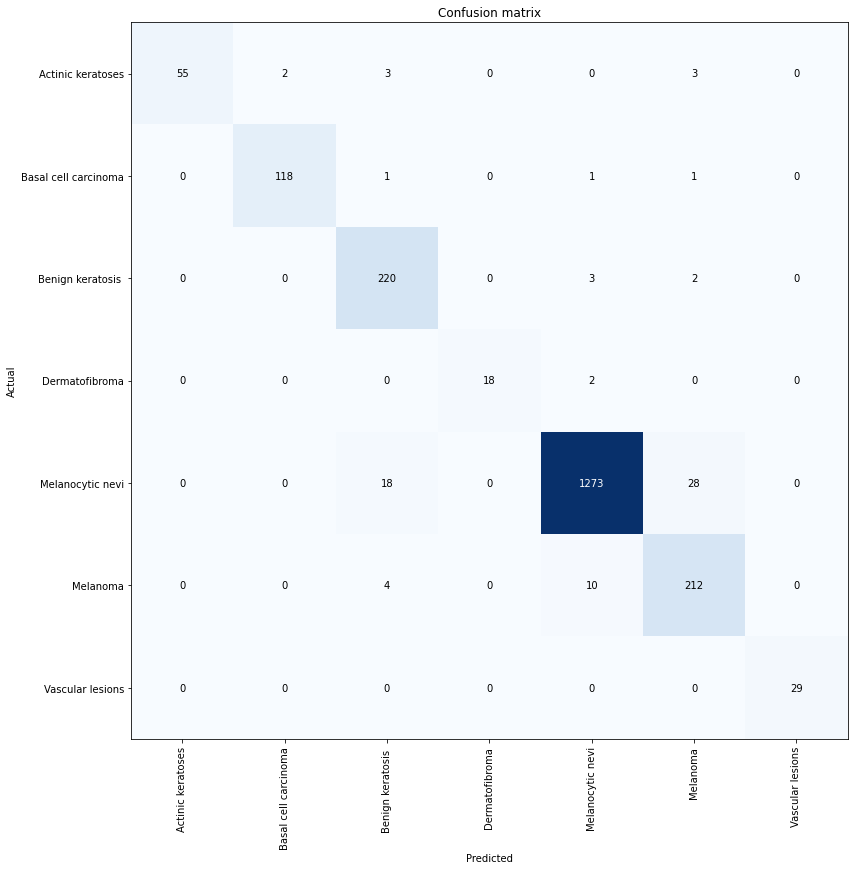

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=72);

# Credit

* https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
* https://www.bualabs.com/archives/4102/tutorial-fastai2-oxford-pets-dog-cat-37-class-machine-learning-deep-neural-networks-image-classification-ep-7/
* https://kornia.readthedocs.io/en/latest/losses.html#kornia.losses.FocalLoss